In [82]:
import os
from dotenv import load_dotenv
from langchain_aws import ChatBedrock
from botocore.config import Config
import boto3
from langchain_openai import ChatOpenAI

load_dotenv()

def llm_llama():
    
    config = Config(read_timeout=120)
    AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
    AWS_ACCESS_KEY= os.getenv("AWS_ACCESS_KEY_ID")

    client = boto3.client('bedrock-runtime', region_name='us-west-2',config=config, aws_access_key_id=AWS_ACCESS_KEY, aws_secret_access_key=AWS_SECRET_ACCESS_KEY,)
 
    llm = ChatBedrock(
        client=client,
        model_id="arn:aws:bedrock:us-west-2:585008056358:inference-profile/us.meta.llama3-3-70b-instruct-v1:0",
        provider="meta",
        model_kwargs={"temperature": 0},
        region="us-west-2"
    )

    return llm
#us.meta.llama3-3-70b-instruct-v1:0
#meta.llama3-3-70b-instruct-v1:0
#mistral.mistral-large-2402-v1:0

def llm_4o():
    llm  = ChatOpenAI(model="gpt-4o-2024-11-20", temperature=0, api_key=os.getenv("OPENAI_API_KEY"))
    return llm

In [34]:
from twelvedata import TDClient
from datetime import datetime, timedelta
import pandas as pd

def get_data(interval, num_candles, date=datetime.now()):
    TWELVE_DATA_API= os.getenv("TWELVE_DATA_API")

    # Format the current time to the required format
    formatted_time = date.strftime("%Y-%m-%d %H:%M:%S")
    td = TDClient(apikey=TWELVE_DATA_API)

    ts = td.time_series(
        symbol="EUR/USD",
        interval=interval,
        outputsize=num_candles,
        timezone="America/New_York",
        order="asc",
        end_date = formatted_time
    )

    return ts.as_pandas()


In [35]:
from langchain_core.prompts import ChatPromptTemplate

def htf_agent_operation(htf_df):
    # HTF agent for identifying the trend bias
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", """
    You are a specialized Forex Market Analyst focusing on higher-timeframe trends using Smart Money Concepts.
    Your job is to:
    1. Determine the overall trend (bullish, bearish, ranging).
    2. Identify major swing points (highs/lows).
    3. Summarize any significant daily order blocks or liquidity zones that are clearly visible (including swing high or low).

    Format your response as:
    - Overall HTF Bias: [bullish/bearish/ranging]
    - Key Swing Highs and Lows: ...
    - Any Notable Liquidity or Order Blocks: ...
    - Brief Explanation (1–2 sentences).

    Important:
    - Do not invent data. If uncertain, say “Not enough info.”
    - Be concise and to the point in your analysis.
    """),
            ("user", "Daily Data"),
            ("user", "{htf_df}"),
            ("user", "Please analyze this data to determine the 4h (HTF) directional bias, major swing points, and any relevant daily order blocks or liquidity pools.")
        ]
    )

    htf_agent_chain = prompt | llm_llama()

    htf_info = htf_agent_chain.invoke({"htf_df": htf_df.to_string()})

    htf_info_structured = htf_info.content

    return htf_info_structured

In [36]:
from langchain_core.prompts import ChatPromptTemplate

def mtf_agent_operation(mtf_df):

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", """
You are an advanced Forex Analyst specializing in Smart Money Concepts on the 1-hour timeframe. Your tasks:

Determine the current trend bias (bullish, bearish, ranging)

Identify 1H Order Blocks
Bullish OB: Typically the last down candle (or small cluster) before an impulsive up move that breaks structure.
Bearish OB: Typically the last up candle (or cluster) before an impulsive down move that breaks structure.
Only consider high-probability OBs where there is clear displacement (strong momentum) away from the zone and a structure shift.
             
Mark Key Liquidity Pools
Above relative equal highs (potential “buy stops” for liquidity).
Below relative equal lows (potential “sell stops” for liquidity).
Notable swing highs/lows where price repeatedly reacts.
Focus on pools that haven’t yet been “swept” or tapped.
             
Locate Fair Value Gaps (FVGs)
Look for 3-candle formations (Candle 1’s high and Candle 3’s low not overlapping, or vice versa) indicating an imbalance.
A high-probability FVG is one that forms alongside a strong displacement and lines up with an OB or liquidity zone.
             
For each OB or FVG, include approximate price boundaries (e.g., 1.0520–1.0535).
If it’s a single swing high/low, you can note that level as well.
             
Format your final analysis as follows:
Current Trend Bias: [bullish / bearish / ranging]
Identified Order Blocks: ...
Liquidity Zones/Level: ...
Fair Value Gaps: ...
Brief Explanation (1 sentence): Summarize the main confluence factors. 

Keep your analysis concise.
             
Important Reminders
Think step by step.
Only highlight high-probability Zones/Levels.
Focus on synergy between OBs, FVGs, and liquidity sweeps for a solid SMC approach.
    """),
            ("user", "1H Data"),
            ("user", "{mtf_df}"),
        ]
    )

    mtf_agent_chain = prompt | llm_llama()

    mtf_info = mtf_agent_chain.invoke({"mtf_df": mtf_df.to_string()})

    mtf_info_structured = mtf_info.content

    return mtf_info_structured

In [37]:
from pydantic import BaseModel, Field
from typing import Optional

def trade_decision_operation(htf_info_structured, mtf_info_structured, ltf_df):

    class Schema(BaseModel):
        enter_market: bool = Field(description="This variable stores the trade decision.")
        trade_type: Optional[str] = Field(description="This variable stores the type of trade(long or short).")
        entry_price: Optional[float] = Field(description="This variable stores the entry price of the trade.")
        stop_loss: Optional[float] = Field(description="This variable stores the stop loss price of the trade.")
        take_profit: Optional[float] = Field(description="This variable stores the take profit price of the trade.")
        confident_level: Optional[int] = Field(description="This variable stores the confidence level of the trade.")
        explanation: str = Field(description="This variable stores the explanation of the trade and/or the decision.")

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", """
You are the Head Trader at a Forex Hedge Fund, analyzing EURUSD using Smart Money Concepts. Your tasks:

Gather & Interpret HTF/MTF Analysis
Confirm HTF bias (bullish or bearish).
Check MTF alignment; if they conflict, only trade if RR is high.
             
Locate Key Price Levels
Identify order blocks, fair value gaps (FVG), liquidity pools, or strong S/R.
No trade if price sits in a choppy/ranging structure with no clear advantage.
             
Candlestick Confirmation
Wait for strong displacement or clear reversal candle (e.g., engulfing, shooting star) confirming direction.
Don’t enter immediately upon a liquidity sweep; wait for price to shift structure and show momentum.
             
Stop Loss & Take Profit
Generally, target the key levels or fib ratio which ever yield higher RR
Stop loss: Place safely outside the order block/FVG, giving room for typical wicks.
Take profit: Target next major liquidity zone or FVG boundary. Consider partials at intermediate levels to lock gains.
Keep a higher reward-to-risk ratio (≥2:1 ideally).
             
Confidence Level
Only pull the trigger when alignment is solid and the setup meets your strict criteria.
If HTF and MTF diverge, skip or only take the trade if everything else screams high probability.
             
Explanation
Provide a concise reasoning: HTF–MTF alignment, key levels, candlestick trigger, and your final R:R.
Remember: Profit is the objective—avoid forcing trades if conditions aren’t there.
Stay disciplined: No overtrading, no “hope trades,” , always protect capital, and think step by step.
    """),
            ("user", "HTF Analysis"),
            ("user", "{htf_analysis}"),
            ("user", "MTF Analysis"),
            ("user", "{mtf_analysis}"),
            ("user", "Market data"),
            ("user", "{ltf_df}"),
            ("system", "If no trade opportunity is found, please avoid unncessary output.")
        ]
    )

    trade_agent_chain = prompt | llm_4o().with_structured_output(Schema)

    trade_info = trade_agent_chain.invoke({"htf_analysis": htf_info_structured, 
                                        "mtf_analysis": mtf_info_structured, 
                                        "ltf_df": ltf_df[-75:].to_string()})

    return trade_info

In [38]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
#simulation
MONGODB_CONNECTION_STRING_URL= os.getenv("MONGODB_CONNECTION_STRING_URL")

client = MongoClient(MONGODB_CONNECTION_STRING_URL, server_api=ServerApi('1'))

db = client["data_insights"]

trade_details = []
mtf_info_structured = None
htf_info_structured = None
data = get_data("15min", 5000)
in_trade = False
short_trade = False
balance = 1000
margin = 10
trade_details = []

In [56]:
def run_sim(trade_detail, df):
    sl = trade_detail["stop_loss"]
    tp = trade_detail["take_profit"]
    trade_type = trade_detail["trade_type"]
    num_index = 0
    for index, row in df.iterrows():
        if trade_type == "long":
            if row["low"] < sl:
                return sl, num_index+1
            if row["high"] > tp:
                return tp, num_index+1
        else:
            if row["high"] > sl:
                return sl, num_index+1
            if row["low"] < tp:
                return tp, num_index+1
        num_index += 1
        
    return None, None
                

In [57]:

num_index = 0
for index, row in data.iterrows():
    timestamp = pd.to_datetime(row.name)
    uk_open = timestamp.replace(hour=3, minute=0, second=0)
    ny_open = timestamp.replace(hour=8, minute=0, second=0)
    ny_extended = timestamp.replace(hour=10, minute=0, second=0)

    if uk_open <= timestamp <= ny_extended and  timestamp.minute == 0:
        if num_index < 75:
            ltf_df = data.iloc[:num_index]
        else:
            ltf_df = data.iloc[num_index-75:num_index]

        trade_info =trade_decision_operation(htf_info_structured, mtf_info_structured, ltf_df)
        print(trade_info.model_dump())
        
        if trade_info.enter_market:
            trade_details.append(trade_info.model_dump())
            close_price, holding_time = run_sim(trade_info.model_dump(), data.iloc[num_index:])
            if close_price == None:
                continue
            else:
                trade_details[-1]["close_price"] = close_price
                trade_details[-1]["holding_time"] = holding_time
                trade_details[-1]["balance"] = balance
                trade_details[-1]["margin"] = margin
                if trade_details[-1]["trade_type"] == "long":
                    trade_details[-1]["profit"] = (trade_details[-1]["close_price"] - trade_details[-1]["entry_price"]) * margin * balance
                else:
                    trade_details[-1]["profit"] = (trade_details[-1]["entry_price"] - trade_details[-1]["close_price"]) * margin * balance
                balance += trade_details[-1]["profit"]
                trade_details[-1]["balance_after_trade"] = balance
            
            data_chunk = trade_details[-1]
            print(data_chunk)
            db.trades.insert_one({"data": data_chunk})

    if timestamp == uk_open or timestamp == ny_open:
        mtf_df = get_data("1h", 200, timestamp)
        mtf_info_structured = mtf_agent_operation(mtf_df)
        data_chunk ={
            "timestamp": timestamp,
            "analysis": mtf_info_structured
        }
        db.data_insight_1h.insert_one(data_chunk)

    if num_index % 192 == 0:
        htf_df = get_data("4h", 100, timestamp)
        htf_info_structured = htf_agent_operation(htf_df)
        data_chunk ={
            "timestamp": timestamp,
            "analysis": htf_info_structured
        }
        db.data_insight_4h.insert_one(data_chunk)
    
    num_index += 1
        

{'enter_market': True, 'trade_type': 'short', 'entry_price': 1.086, 'stop_loss': 1.0872, 'take_profit': 1.0845, 'confident_level': 80, 'explanation': 'The HTF and MTF trends are both bearish, aligning with the overall market sentiment. The price is currently near a bearish order block between 1.0868 - 1.0872, which is a key level. Recent candlestick patterns show a consistent downward movement, confirming bearish momentum. A short trade is suggested with an entry at 1.0860, stop loss at 1.0872 (above the order block), and take profit at 1.0845 (next significant liquidity zone). Confidence level is 80% due to alignment of trends and key levels.'}
{'enter_market': True, 'trade_type': 'short', 'entry_price': 1.086, 'stop_loss': 1.0872, 'take_profit': 1.0845, 'confident_level': 80, 'explanation': 'The HTF and MTF trends are both bearish, aligning with the overall market sentiment. The price is currently near a bearish order block between 1.0868 - 1.0872, which is a key level. Recent candle

In [72]:
art_trade_details = []
for trade in db.trades.find({}).sort("_id", 1):
    art_trade_details.append(trade["data"])
    print(trade['data'])


{'enter_market': True, 'trade_type': 'short', 'entry_price': 1.0855, 'stop_loss': 1.0865, 'take_profit': 1.082, 'confident_level': 75, 'explanation': 'The HTF trend is bearish, aligning with the overall market sentiment. The price is currently near the bearish order block identified in the MTF analysis (1.08550 - 1.08650). A short trade is considered with a stop loss above the bearish order block and a take profit at the liquidity zone below relative equal lows (1.08200). The confidence level is moderate due to the ranging nature of the MTF trend.', 'close_price': 1.082, 'holding_time': 36, 'balance': 1000, 'margin': 10, 'profit': 34.999999999998366, 'balance_after_trade': 1034.9999999999984}
{'enter_market': True, 'trade_type': 'short', 'entry_price': 1.08587, 'stop_loss': 1.0872, 'take_profit': 1.0845, 'confident_level': 80, 'explanation': 'The HTF and MTF trends are both bearish, aligning with the overall market sentiment. The price is currently near a bearish order block (1.0868 - 

In [77]:
long_count = 0
short_cpunt = 0
profitable_trades = 0
profitable_long = 0
profitable_short = 0
reward_risk_ratio = []
average_loss = 0
average_profit = 0
num_of_trade = 0
no_trade_count = 0
for trade in art_trade_details:
    if trade["enter_market"]:
        num_of_trade += 1
        print(trade["profit"])
        if trade["profit"] > 0:
            profitable_trades += 1
            if trade["trade_type"] == "long":
                profitable_long += 1
            else:
                profitable_short += 1
        if trade["trade_type"] == "long":
            long_count += 1
        else:
            short_cpunt += 1
        reward_risk_ratio.append(abs((trade["take_profit"] - trade["entry_price"]))/abs(trade["entry_price"] - trade["stop_loss"]))
        if trade["profit"] < 0:
            average_loss += trade["profit"]
        else:
            average_profit += trade["profit"]
    else:
        no_trade_count += 1

average_loss = average_loss/len(trade_details)
average_profit = average_profit/len(trade_details)
reward_risk_ratio = sum(reward_risk_ratio)/len(reward_risk_ratio)
print(f"Total Trades: {num_of_trade}")
print(f"No Trade Count: {no_trade_count}")
print(f"Long Trades: {long_count}")
print(f"Short Trades: {short_cpunt}")
print(f"Profitable Trades: {profitable_trades}")
print(f"Profitable Long Trades: {profitable_long}")
print(f"Profitable Short Trades: {profitable_short}")
print(f"Average Loss: {average_loss}")
print(f"Average Profit: {average_profit}")
print(f"Reward Risk Ratio: {reward_risk_ratio}")
print(f"Balance: {balance}")




34.999999999998366
14.179499999998646
15.737692500000552
14.589365537248597
14.03358525448505
10.935401432916109
11.044755447245256
10.039682701545928
19.359631705422508
19.692617370755766
12.344889658666645
18.12513967276609
17.926233919216422
-6.065042476000662
-6.034717263620663
18.013631031907686
24.378447329851067
-18.64951220733676
24.493026032301355
-9.24366802459006
-13.266937057962537
-4.53854477348959
12.220951777914626
-18.51474194353931
-14.10329609645604
-12.016980915291128
-11.896811106138228
-17.666764492617904
-11.6011753501507
-5.742581798324602
-17.14160666799895
28.140804279967487
28.84432438696666
29.565432496640813
30.30456830905682
31.06218251678322
25.470989663762793
25.98040945703805
-27.295018175563502
31.40448191202597
39.87331038136357
39.97432276766202
39.02813602368479
42.281194564369365
37.256682744561246
38.188099813175256
-4.697136277020137
-10.927104692441183
23.251317770562235
22.026748367979536
23.930488762640387
40.48241015679761
-24.896682246431993


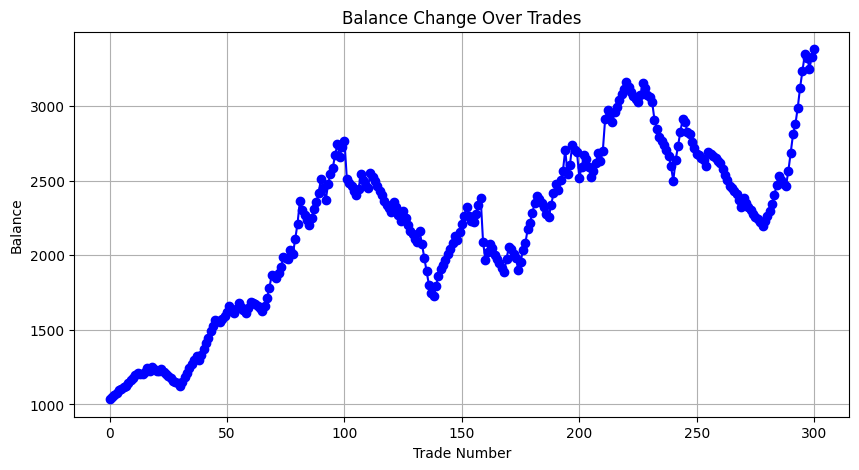

In [78]:
import matplotlib.pyplot as plt

# Extract balance after each trade
balances = [trade["balance_after_trade"] for trade in art_trade_details]

# Plot the balance change
plt.figure(figsize=(10, 5))
plt.plot(balances, marker='o', linestyle='-', color='b')
plt.title('Balance Change Over Trades')
plt.xlabel('Trade Number')
plt.ylabel('Balance')
plt.grid(True)
plt.show()